# Nuage Compta et la facture s'analysa

## 0. Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle

Using TensorFlow backend.


## 1. Import des Dataset

In [2]:
### ImageDataGenerator génère des lots de données d'image vectorielles, convertissant les coefficients RVB compris entre 0 et 255 en valeurs cibles comprises entre 0 et 1 par mise à l'échelle avec un facteur de 1/255 à l' aide de la remise à l' échelle
#        shear_range est utilisé pour appliquer de manière aléatoire des transformations de cisaillement .
#        zoom_range est utilisé pour zoomer aléatoirement à l'intérieur des images.
#       horizontal_flip est utilisé pour retourner au hasard la moitié des images horizontalement.
### Ensuite, nous importons les images une par une à partir des répertoires en utilisant .flow_from_directory et y appliquons ImageDataGenerator.
### Nous convertissons ensuite les images de leur taille d'origine à notre target_size et déclarons le nombre batch_size qui fait référence au nombre d'exemples d'entraînement utilisés dans une itération.
### Ensuite, nous définissons le class_mode sur catégorique indiquant que nous avons plusieurs classes (a à z) à prédire. ###

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory = "Training",
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"

)

test_generator = test_datagen.flow_from_directory(
    directory = "Testing",
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"

)

Found 5200 images belonging to 26 classes.
Found 775 images belonging to 26 classes.


## 2. Definition du model d'architecture 

In [3]:
### Création d'un modèle séquentiel qui permet de définir l'architecture CNN couche par couche à l'aide de la fonction .add .Nous ajoutons d'abord une couche de convolution avec 32 filtres de taille 3X3 sur les images d'entrée et la passons à travers la fonction d'activation 'relu'.Nous effectuons ensuite des opérations MaxPooling en utilisant un pool de taille 2X2.Ces couches sont ensuite répétées à nouveau pour améliorer les performances du modèle.Enfin, nous aplatissons notre matrice résultante et la passons à travers une couche dense composée de 128 nœuds. Celui-ci est ensuite connecté à la couche de sortie constituée de 26 nœuds, chaque nœud représentant un alphabet. Nous utilisons l' activation softmax qui convertit les scores en une distribution de probabilité normalisée, et le nœud avec la probabilité la plus élevée est sélectionné comme sortie. Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam ###

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (32,32,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 26, activation = "softmax"))


model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_2 (Dense)              (None, 26)               

## 3. Entrainement du modele

In [4]:
### Je décide de créer 20 répétitions, et j'ai X2 les steps_per_epoch pour augmenter notre précision ###
entrainement = model.fit_generator(train_generator,
                         steps_per_epoch = 32,
                         epochs = 20,
                         validation_data = test_generator,
                         validation_steps = 32)

Epoch 1/20
32/32 [==============================] - 4s 115ms/step - loss: 3.0659 - accuracy: 0.1523 - val_loss: 2.6296 - val_accuracy: 0.2983
Epoch 2/20
32/32 [==============================] - 3s 96ms/step - loss: 2.1008 - accuracy: 0.3994 - val_loss: 1.5886 - val_accuracy: 0.5045
Epoch 3/20
32/32 [==============================] - 3s 97ms/step - loss: 1.4512 - accuracy: 0.5596 - val_loss: 1.4448 - val_accuracy: 0.6066
Epoch 4/20
32/32 [==============================] - 3s 96ms/step - loss: 1.1984 - accuracy: 0.6349 - val_loss: 1.2573 - val_accuracy: 0.7043
Epoch 5/20
32/32 [==============================] - 3s 90ms/step - loss: 1.0565 - accuracy: 0.6562 - val_loss: 0.7530 - val_accuracy: 0.7237
Epoch 6/20
32/32 [==============================] - 3s 108ms/step - loss: 0.8706 - accuracy: 0.7133 - val_loss: 1.2671 - val_accuracy: 0.7588
Epoch 7/20
32/32 [==============================] - 4s 124ms/step - loss: 0.8672 - accuracy: 0.7266 - val_loss: 0.8612 - val_accuracy: 0.7698
Epoch 8/20

## 4. Enregistrement & chargement du modele

In [5]:
pickle.dump(model, open("CNN_model.sav", "wb"))

In [6]:
model = pickle.load(open("CNN_model.sav","rb"))

## 5. Création d'une fonction qui renvois l'alphabet associé au résultat.

In [7]:
def get_result(result):
    if result[0][0] == 1:
        return("a")
    elif result[0][1] == 1:
        return ("b")
    elif result[0][2] == 1:
        return ("c")
    elif result[0][3] == 1:
        return ("d")
    elif result[0][4] == 1:
        return ("e")
    elif result[0][5] == 1:
        return ("f")
    elif result[0][6] == 1:
        return ("g")
    elif result[0][7] == 1:
        return ("h")
    elif result[0][8] == 1:
        return ("i")
    elif result[0][9] == 1:
        return ("j")
    elif result[0][10] == 1:
        return ("k")
    elif result[0][11] == 1:
        return ("l")
    elif result[0][12] == 1:
        return ("m")
    elif result[0][13] == 1:
        return ("n")
    elif result[0][14] == 1:
        return ("o")
    elif result[0][15] == 1:
        return ("p")
    elif result[0][16] == 1:
        return ("q")
    elif result[0][17] == 1:
        return ("r")
    elif result[0][18] == 1:
        return ("s")
    elif result[0][19] == 1:
        return ("t")
    elif result[0][20] == 1:
        return ("u")
    elif result[0][21] == 1:
        return ("v")
    elif result[0][22] == 1:
        return ("w")
    elif result[0][23] == 1:
        return ("x")
    elif result[0][24] == 1:
        return ("y")
    elif result[0][25] == 1:
        return ("z")

## 6. Choix de l'image à envoyer 

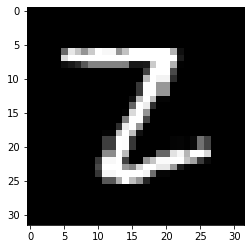

In [33]:
choix = r'Testing/z/Z-246.png'
test_image = image.load_img(choix, target_size = (32,32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)



## 7. Test du model

In [34]:
resultat = model.predict(test_image)
resultat = get_result(resultat)
print(f"La lettre correspondante est: {resultat}")

La lettre correspondante est: z
